# Neural Network FIR Filter

Julien Doe

## Background

Filtering is one of the most fundamental operations in digital signal processing. It is the process of selectively keeping some frequncies from an input signal while removing others. In the digital world, it is accomplished using simple multiplcation and addition operations.

Finite Impulse Response (FIR) filters are one of the most common forms of filters. Along with having many desirable signal processing properties, which we won't discuss in depth here, they are also simple to implement. They are simply a weighted sum of previous and past input samples. The weights, or "coefficients", determine the frequency response of the filter. That is to say, it determines which frequencies are passed and which are attenuated.

To a machine learning engineer, this structure should sound familiar: it is identical to a single node in a dense neural network, where the inputs are time delayed samples of the input signal, and there is no activation function (we want filters to be linear operations).

Usually filters are designed by choosing an ideal frequency response and number of coefficients, then running an algorithm to derive coefficients which fit the desired response as closely as it can. There is always a design trade here: more coefficients will be able to more closely match the ideal response, but at the cost of more computational complexity. It is generally desirable to both improve the frequency response and reduce the number of coefficients. 

All current filter design algorithms are rules-based approaches. However, given the similarity between an FIR filter and a neural network node, a couple questions are raised:

1. Can a neural network be used to derive FIR filter coefficients?
2. Can a neural network improve on existing algorithms? In other words, can it generate a better frequency response with the same number of coefficients, or equivalent performance with less coefficients?

This notebook will investigate these two questions

## Imports

In [734]:
# Common
import os
import numpy as np
import scipy as sp
import pandas as pd

# DSP
from scipy.signal import convolve, upfirdn
from scipy.signal import firls
from scipy.fft import fft, fftshift
from math import log10

# Neural Network
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Lambda
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt

## Constants

Some notes:

- We want to make the filter relatively long so it looks similar to an ideal lowpass filter for the given frequency response

In [712]:
# Filter
nfir = 65

# Data
ntones = 32
nsamples = 10**3

# Quantization
nbits = 16
scale_factor = 2**(nbits-1)-1

# Display
nfft = 2**13

## Reference FIR Filter

For this analysis we will look at a simple lowpass FIR filter. This section derives the filter coefficients and plots the response.

### Helper Functions

Plot coefficients

In [713]:
def plot_coefs(coefs, nfft=2**15):
    # Plot Impulse Response
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(coefs)
    ax[0].grid()
    ax[0].set_title('Filter Impulse Response')
    ax[0].set_xlabel('n')
    ax[0].set_ylabel('h[n]')

    # Plot magnitude response
    f = np.linspace(-0.5, 0.5, nfft, endpoint=False)
    Hf = 20 * np.log10(abs(fftshift(fft(coefs, nfft))))
    ax[1].plot(f, Hf)
    ax[1].grid()
    ax[1].set_title('Filter Magnitude Response')
    ax[1].set_xlabel('f')
    ax[1].set_ylabel('|H(f)|')

    plt.tight_layout()

### Coefficient Derivation

We will derive a simple FIR filter using the `scipy` `firls()` function and plot the response:

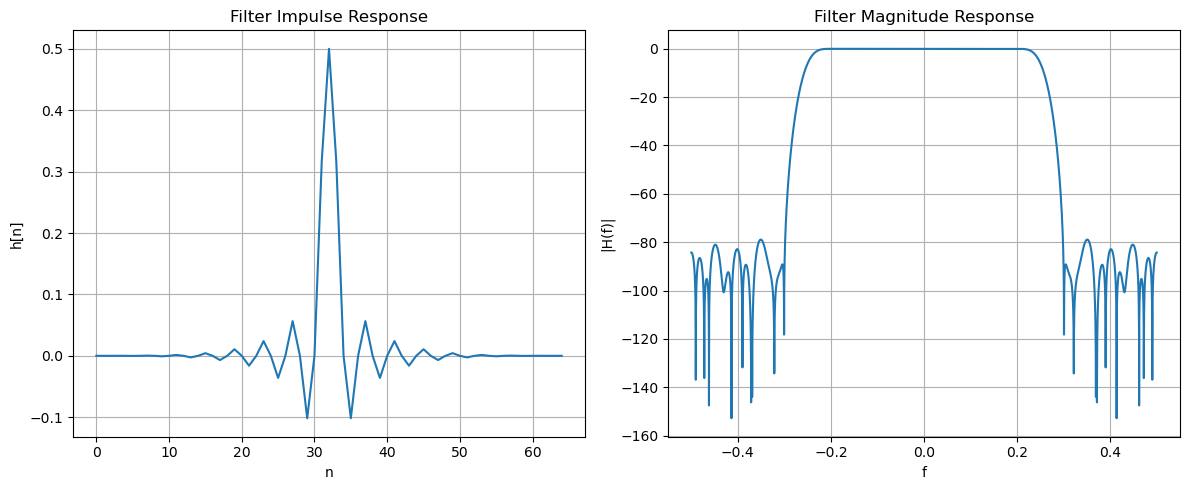

In [714]:
# Filter parameters
bands = [0, 0.2, 0.3, 0.5]
mags = [1, 1, 0, 0]

# Floating point coefficients
coefs = firls(nfir, bands, mags, fs=1)

# Quantize
coefs = np.round(coefs * scale_factor) / scale_factor

# Plot
plot_coefs(coefs, nfft=nfft)

plt.tight_layout()

## Data

To create a neural network we will need filter input and output data. This section generates input data and uses the derived filter coefficients to calculate output samples.

### Helper Functions

Take a signal and create Dataframe of all taps, as well as filter output

In [715]:
def make_dataframe(x, coefs):
    # Get sizing information
    ncoefs = len(coefs)
    nlags = ncoefs - 1

    # Initialize dataframe
    df = pd.DataFrame({'x':x})

    # Add lags
    for lag in range(0, ncoefs):
        df['n' + str(nlags-lag)] = df['x'].shift(-1*lag)

    # Drop rows with nulls
    df = df.dropna(how='any', axis='index')

    # Calculate filter outputs
    df['y'] = df.drop(columns='x').dot(coefs)

    # Return
    return df

Plot input & output magnitude responses

In [729]:
def plot_dataframe(df, nfft=None):
    # Resolve FFT size
    if nfft is None:
        nfft = df.shape[0]
    
    # FFTs (no averaging for now)
    f = np.linspace(-0.5, 0.5, nfft, endpoint=False)
    Xf = abs(fftshift(fft(df['x'].values, nfft)))
    Yf = abs(fftshift(fft(df['y'].values, nfft)))
    Xf[Xf == 0.0] = np.finfo(float).eps
    Yf[Yf == 0.0] = np.finfo(float).eps
    Xf = 20 * np.log10(Xf)
    Yf = 20 * np.log10(Yf)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(f, Xf)
    ax[0].grid()
    ax[0].set_title('Input Data')
    ax[0].set_xlabel('f')
    ax[0].set_ylabel('|X(f)|')

    ax[1].plot(f, Yf)
    ax[1].grid()
    ax[1].set_title('Output Data')
    ax[1].set_xlabel('f')
    ax[1].set_ylabel('|Y(f)|')

    plt.tight_layout()

### White Gaussian Noise

Using the coefficients, we will create training data for the network using white Gaussian noise. Noise is useful as it covers the entire frequency spectrum.

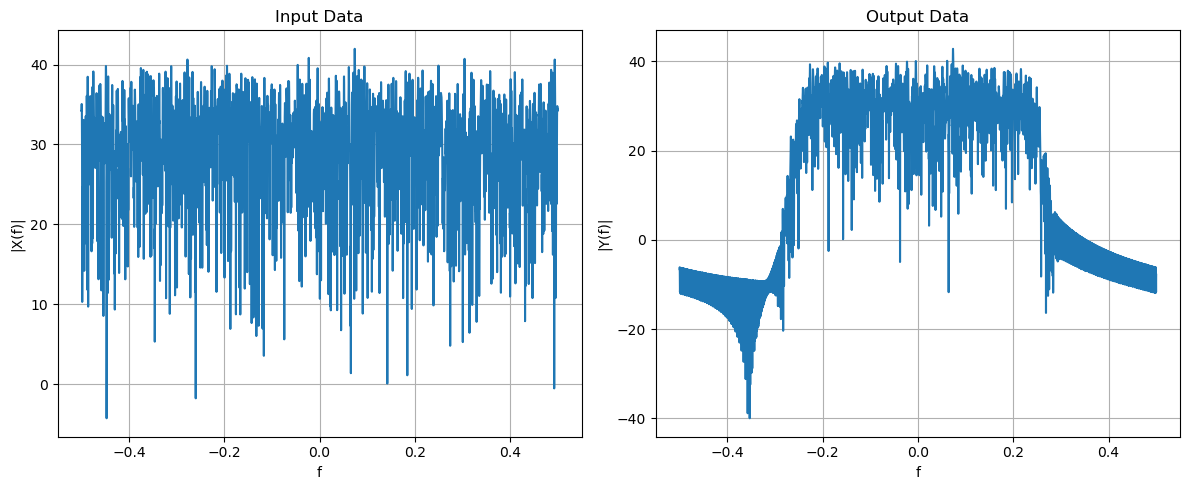

In [717]:
# Generate white Gaussian noise
x = np.random.normal(0, 1, nsamples) + 1j*np.random.normal(0, 1, nsamples)

# Quantize
x = np.round(x * scale_factor) / scale_factor

# Make dataframe
df_wgn = make_dataframe(x, coefs=coefs)

# Plot
plot_dataframe(df_wgn, nfft=nfft)

## Neural Network

With our filter coefficients and dataset generated, we can start to investigate a neural network filter implementation.

### Helper Functions

Split data into train and test data

In [730]:
def split_dataframe(df, test_split=0.2, nweights=None):
    # Define x and y
    x = np.real(df.drop(columns=['x', 'y']).values)
    y = np.real(df['y'].values)

    # Trim x
    if nweights is not None:
        x = x[:, 0:nweights]

    # Split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_split)

    # Return
    return x_train, x_test, y_train, y_test

Generate model at specified length

In [719]:
def generate_model(nweights, name='NeuralFilter'):
    # Construct model using functional API
    inputs = Input(shape=(nweights,))
    x = inputs #= SymmetricPreAdd()(inputs)
    outputs = Dense(1, 
        activation=None, 
        use_bias=False, 
        kernel_initializer = 'glorot_uniform', #keras.initializers.RandomUniform(minval=-scale_factor-1, maxval=scale_factor),
        kernel_regularizer = None, #PassbandFlatness(fs=1, pb2s=0.4, nfft=nfft), #keras.regularizers.l1(0.001), 
        dtype='float32')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)

    # Compile
    model.compile(
        loss='mean_absolute_error', 
        optimizer=keras.optimizers.Adam(0.1), 
        metrics=['mean_absolute_error'])

    # Return
    return model

### Training Callbacks

Callbacks wrapped in functions so that they can be called multiple times over training runs.

Early stopping

In [720]:
def get_early_stopping():
    return keras.callbacks.EarlyStopping(
        monitor='loss',
        mode='min',
        patience=5, 
        restore_best_weights=True, 
        start_from_epoch=0)

Reduce learning rate on plateaus. If using with `EarlyStopping` we want to be sure it has less patience so it has a chance to decrease the learning rate before training is stopped.

In [721]:
def get_lr_plateau():
    return keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        mode='min',
        factor=0.1,
        patience=0)

### Relearning the Filter

Using the generated data, we will first attempt to train a single unit neural network to relearn the coefficients

Model: "Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_202 (InputLayer)    │ (None, 65)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65 (260.00 B)

 Trainable params: 65 (260.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 3.0821 - mean_absolute_error: 3.0821 - learning_rate: 0.1000
Epoch 2/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 194us/step - loss: 3.1607 - mean_absolute_error: 3.1607 - learning_rate: 0.1000
Epoch 3/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step - loss: 2.3651 - mean_absolute_error: 2.3651 - learning_rate: 0.0100
Epoch 4/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 0.3337 - mean_absolute_error: 0.3337 - learning_rate: 0.0100
Epoch 5/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.3108 - mean_absolute_error: 0.3108 - learning_rate: 0.0100
Epoch 6/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.3061 - mean_absolute_error: 0.3061 - learning_rate: 0.0100
Epoch 7/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step - loss: 0.2994 - mean_absolute_error: 0.2994 - learning_rate: 0.0100
Epoch 8/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.3218 - mean_absolute_error: 0.3218 - learning_rate: 0.0100
Epoch 9/

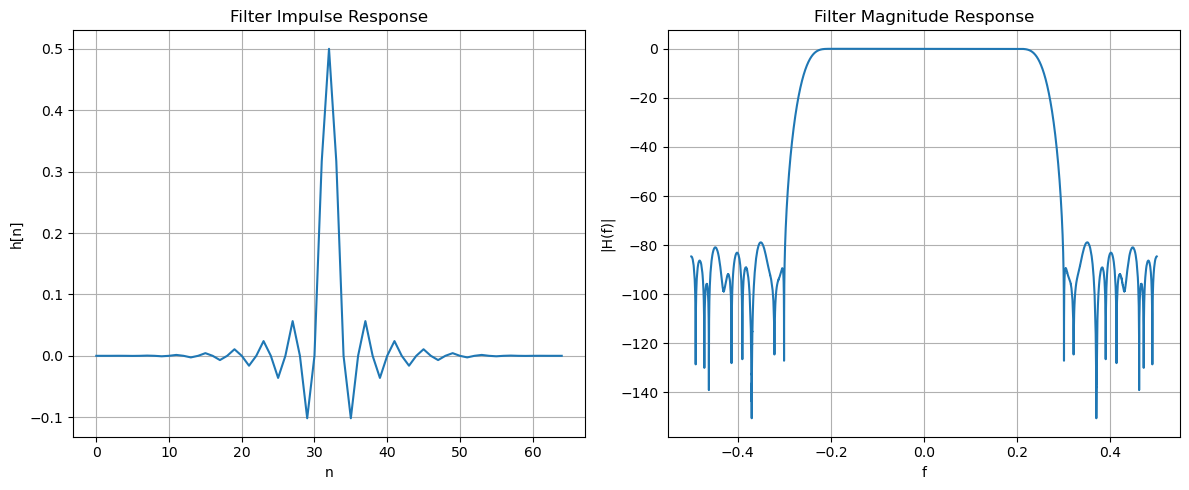

In [722]:
# Generate model
base = generate_model(len(coefs), name='Baseline')
base.summary()

# Split data
x_train, x_test, y_train, y_test = split_dataframe(df_wgn, test_split=0.2)

# Train
history = base.fit(
    x_train, 
    y_train,
    batch_size=1, 
    epochs=100,
    callbacks=[get_lr_plateau(), get_early_stopping()])

# Evauluate
metrics = base.evaluate(x_test, y_test)
print("Test MAE:", metrics[1])

# Get coefficients
# - First [1] is indexing dense layer
# - Next [0] is indexing weights, as opposed to biases
# - Last [:, 0] is indexing all weights for first (only) unit
weights = base.layers[1].get_weights()[0][:, 0]
nn_coefs = weights

## Saved code for Symmetric Pre-Add
#if weights.shape[0] % 2 == 1:
#    nn_coefs = np.concatenate([weights, np.flipud(weights)[1:]])
#else:
#    nn_coefs = np.concatenate([weights, np.flipud(weights)])

# Plot
plot_coefs(nn_coefs)

From the training results and the plots, we can see that the network looks like it learned the fitler coefficients correctly

### Notes on Model

Notes from all the tinkering and testing that went in to the model above:
- We want to use MAE as it directly maps to error on the output samples. It is analogous to quantization error, except that is usually between an ideal signal and its fixed point version, whereas this is between a reference filter and the optimized version. It can be tracked similarly to quantization error and rolled up into implementation loss

- Unlike most ML applications, we don't actually care much about testing performance since we can evaluate the output coefficients directly. However it still works as a good first line metric to see how well the training performed.

- Training doesn't seem to work for a batch size > 1. In other words, a true stochastic gradient descent works best. Suspect this is because the input data is noise, so single errors & gradients may likewise look like noise, and averaging over multiple errors averages away any change

- After a point, more input samples doesn't seem to have any benefit to training and just makes the epochs longer (especially since we are using stochastic gradient descent). Seems to work better to have a smaller training set size and more epochs

- Training with a large learning rate quickly hits a plateau, but a small rate trains very slowly. It is better to start with a large learning rate and dynamically reduce it as learning plateaus. Using the `ReduceLROnPlateau` callback in combination with the `EarlyStopping` callback seems to work best since it adjusts to the learning real time; better than trying to use `LearningRateScheduler`

- Trying to force symmetry with the custom `SymmetricPreAdd` layer made training struggle. Suspect this is because adding two Gaussian samples together in the pre-add stage just creates a new Gaussian sample. This means the back propagation will have trouble updating gradients as it's acting on different input data.

### Optimizing the Filter

Here we will rerun the training with less weights to see if we can get the same performance with a shorter filter. We will start with a small decrease of 2 coefficients

Model: "Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_235 (InputLayer)    │ (None, 63)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 1)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63 (252.00 B)

 Trainable params: 63 (252.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step - loss: 2.8448 - mean_absolute_error: 2.8448 - learning_rate: 0.1000
Epoch 2/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - loss: 3.2017 - mean_absolute_error: 3.2017 - learning_rate: 0.1000
Epoch 3/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - loss: 1.7529 - mean_absolute_error: 1.7529 - learning_rate: 0.0100
Epoch 4/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - loss: 0.3052 - mean_absolute_error: 0.3052 - learning_rate: 0.0100
Epoch 5/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - loss: 0.2963 - mean_absolute_error: 0.2963 - learning_rate: 0.0100
Epoch 6/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - loss: 0.3034 - mean_absolute_error: 0.3034 - learning_rate: 0.0100
Epoch 7/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - loss: 0.2110 - mean_absolute_error: 0.2110 - learning_rate: 1.0000e-03
Epoch 8/100
748/748 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - loss: 0.0289 - mean_absolute_error: 0.0289 - learning_rate: 1.0000e-03


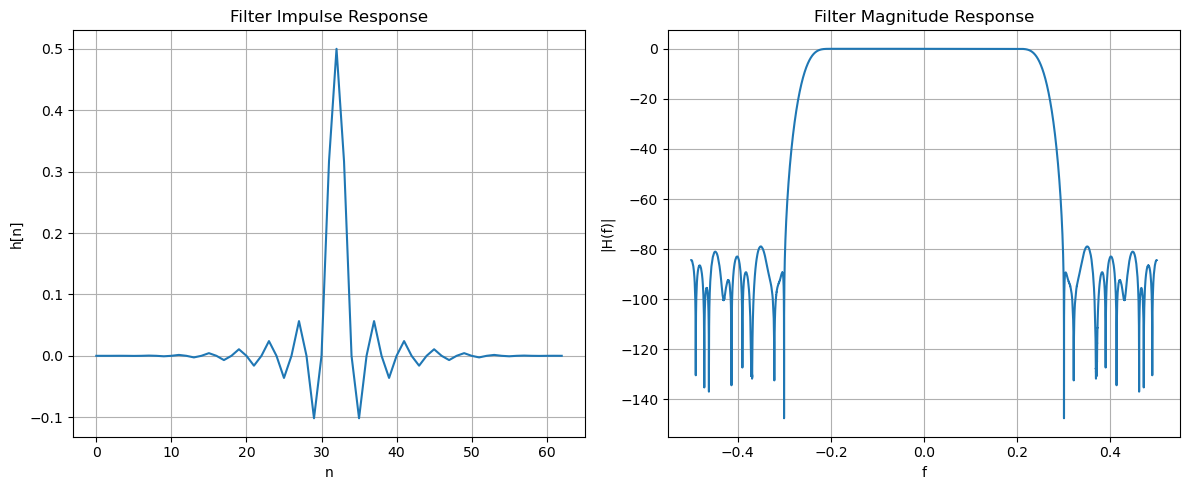

In [732]:
# Generate model
nweights = nfir - 2
opt = generate_model(nweights, name='Optimized')
opt.summary()

# Split data
x_train, x_test, y_train, y_test = split_dataframe(df_wgn, test_split=0.2, nweights=nweights)

# Train
history = opt.fit(
    x_train, 
    y_train,
    batch_size=1, 
    epochs=100,
    callbacks=[get_lr_plateau(), get_early_stopping()])

# Evauluate
metrics = opt.evaluate(x_test, y_test)
print("Test MAE:", metrics[1])

# Plot
weights = opt.layers[1].get_weights()[0][:, 0]
nn_coefs = weights
plot_coefs(nn_coefs)

We can see that the neural network was able to keep the same filter shape while decreasing the number of coefficients. While it was a small optimization, it is a promising result.

### Filter Length Sweep

Since we established the neural network can optimized the filter, the next question is how much can it decrease. We will sweep over decreasing numbers of weights to and look at the results to see where the performance falls off.

In [724]:
# Initialize iteration variables
iter_weights = list(range(nfir, 35, -1))
iter_mse = []

# Iterate over decreasing weights
for nweights in iter_weights:
    # Print iteration
    print(f'Checking {nweights} weights')

    # Generate model
    iter = generate_model(nweights, name='Test')

    # Split data
    x_train, x_test, y_train, y_test = split_dataframe(df_wgn, test_split=0.2, nweights=nweights)

    # Train
    history = iter.fit(
        x_train, 
        y_train,
        batch_size=1, 
        epochs=100,
        callbacks=[get_lr_plateau(), get_early_stopping()], 
        verbose = 0)

    # Save MAE
    iter_mse.append(iter.evaluate(x_test, y_test)[1])

Checking 65 weights
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 7.7245e-07 - mean_absolute_error: 7.7245e-07
Checking 64 weights
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 1.0469e-06 - mean_absolute_error: 1.0469e-06
Checking 63 weights
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 5.2856e-07 - mean_absolute_error: 5.2856e-07
Checking 62 weights
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 7.2343e-07 - mean_absolute_error: 7.2343e-07
Checking 61 weights
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 5.4625e-05 - mean_absolute_error: 5.4625e-05
Checking 60 weights
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 5.2609e-05 - mean_absolute_error: 5.2609e-05
Checking 59 weights
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 1.3520e-04 - mean_absolute_error: 1.3520e-04
Checking 58 weights
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 1.4110e-04 - mean_absolute_error: 1.4110e-04
Checking 57 weights
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 3.1850e-04 - mean_absolute_error: 3.1

We now plot the sweep results.

Note that we are purposely tracking MAE and not MSE since MAE translates direclty to error on the output signal. This error is similar to quantization error, except it is between the original filter and the optimized version. We will plot it in dB format, where the error value can be thought of as a quantization degradation and rolled up into implementation loss.

Text(0, 0.5, 'Mean Average Error (vs Original Filter) [dB]')

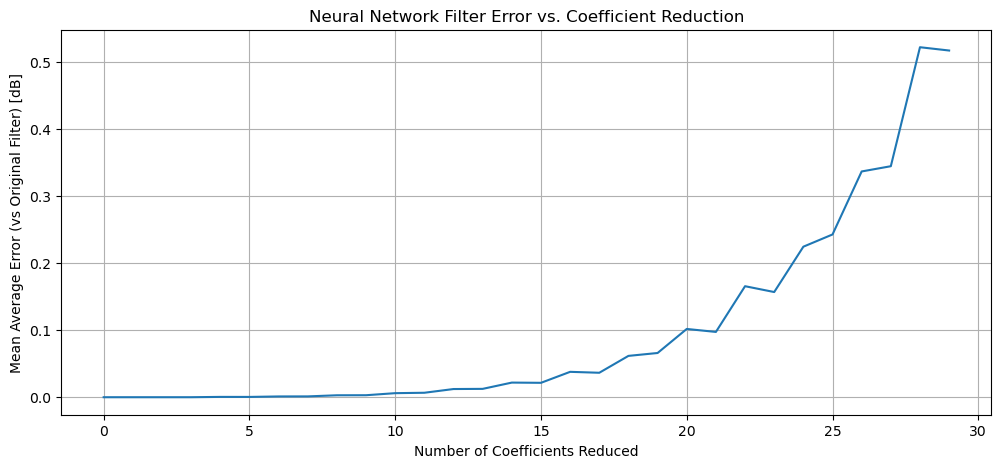

In [725]:
# Derive x and y values
x_iter = [nfir - x for x in iter_weights]
y_iter = 20 * np.log10([1 + x for x in iter_mse]) # Equation is technically (1 + x) / 1, but we can ignore divide by 1

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(x_iter, y_iter)
ax.grid()
ax.set_title('Neural Network Filter Error vs. Coefficient Reduction')
ax.set_xlabel('Number of Coefficients Reduced')
ax.set_ylabel('Mean Average Error (vs Original Filter) [dB]')

We can see that the error remains fairly negligible for reductions up to about 10 coefficients, and after that starts to increase more significantly. The tolerable error would depend on the application.

## Future Work

Ideas for future work

- Figure out how to make filter a lot longer

- Custom loss functions designed around filter ripple and rejection instead of just MAE

- Custom regularizer to force coefficients to powers of 2

## Archive

Below is code that proved to not be useful, but is kept for reference

### Comb of Tones

Using the coefficients, we will create training data for the network using a comb of tones. Tones are useful as they are high SNR and very clearly trace out the filter response.

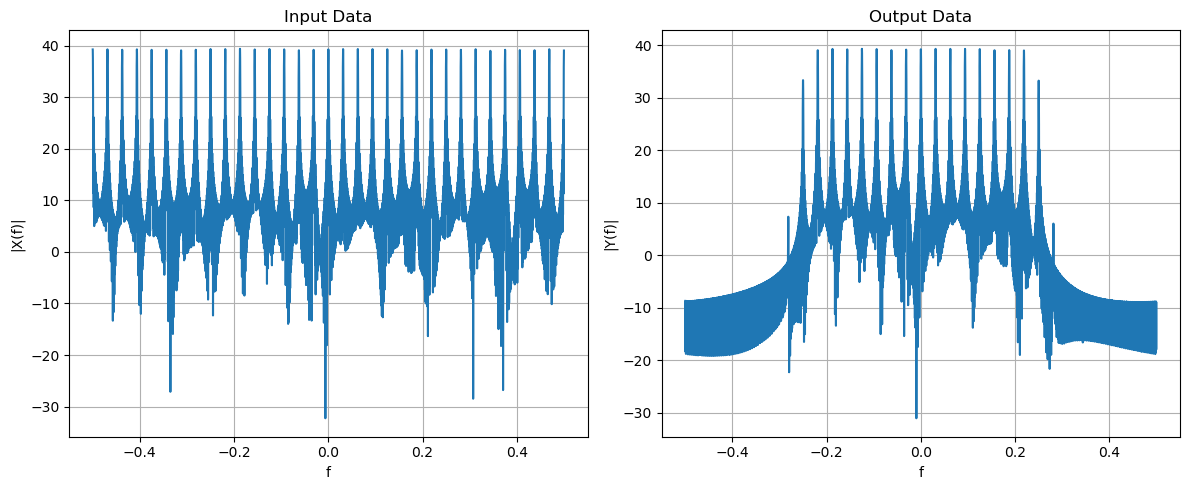

In [726]:
# Generate comb of tones
x = np.zeros((nsamples,), dtype=np.complex64)
for i in range(ntones):
    fnorm = i / ntones
    temp = np.exp(2j * np.pi * fnorm * np.arange(nsamples) + 2j*np.pi*np.random.uniform())
    x = x + temp

# Normalize
norm_factor = np.max([np.max(np.abs(np.real(x))), np.max(np.abs(np.imag(x)))])
x = x / norm_factor

# Quantize
x = np.round(x * scale_factor) / scale_factor

# Make dataframe
df_comb = make_dataframe(x, coefs=coefs)

# Plot
plot_dataframe(df_comb, nfft=nfft)

### Custom Classes

All below were investigated at some point; not all are used in final version. Code left here regardless for posterity.

#### FIR Symmetric Pre-Add Layer

FIR filters are symmetric, and this custom input layer forces symmetry in the subsequent weights.

A custom class ended up being easier to implement than a lambda layer. Some of the operations are a little weird as they use only functions in the `keras.ops` library.

In [727]:
class SymmetricPreAdd(keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, inputs):
        # Flip and add to self
        added = inputs + keras.ops.flip(inputs)

        # Concatenate sections of pre-added vector and inputs
        n = keras.ops.floor_divide(inputs.shape[1], 2)
        split_input = keras.ops.split(inputs, [n, n+1], axis=1)
        split_added = keras.ops.split(added, [n, n+1], axis=1)
        concat = keras.ops.concatenate([split_added[0], split_input[1]], axis=1)

        # Index off relevant section for output
        m = keras.ops.floor_divide(inputs.shape[1]+1, 2)
        outputs = keras.ops.split(concat, [m], axis=1)
        return outputs[0]

#### Passband Flatness Regularizer

A way to regularize the response to force passband flatness. Also limited by needing to use the `keras.ops` library.

In [728]:
class PassbandFlatness(keras.regularizers.Regularizer):
    def __init__(self, fs, pb2s, nfft):
        self.nfft = nfft
        self.n = np.ceil(nfft * (pb2s / 2) / fs).astype(int)

    def __call__(self, weights):
        # Take FFT
        print(weights.shape)
        re = np.pad(weights, (0, self.nfft - len(weights)))
        im = np.zeros((self.nfft,))
        H = keras.ops.fft((re, im)) # This is a tuple, need to manually take magnitude
        Hmag = keras.ops.sqrt(keras.ops.add(keras.ops.square(H[0]), keras.ops.square(H[1])))
        Hmag = 20 * keras.ops.log10(Hmag)

        # Find passband
        Hpass = Hmag[0:self.n]
        #Hpass = keras.ops.split(Hmag, [self.n, self.n+1], axis=1)

        # Return ripple
        return keras.ops.max(Hpass) - keras.ops.min(Hpass)